In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,appearance_model_eight_teeth,appearance_model_four_teeth,load_image,load_landmark,gaussian_pyramid_down,tooth_splitter,tooth_models
from incisorseg.utils import *
from active_shape_models.models import GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.shape import Shape, ShapeList,LineGenerator
import json
data = Dataset('../data/')

In [2]:
class AppearanceModel:
    """
        An appearance model used to quickly find an initial solution using
        normalized cross correlation based template matching in a zone restricted
        by the centroid of the training shapes
        Attributes:
            _template: The template generated from the training_images
            _init_shape: The centroid used by the PDM for initialization
            _extent_scale: The [x,y] scaling factor to control the mask for template search


        Authors: David Torrejon and Bharath Venkatesh
    """

    def _build_template(self, training_images, pdm):
        """
        Builds the template that need to be matched
        :param training_images: The set of training images
        :param pdm: A point distribution model built from the corresponding landmarks
        """
        landmarks = pdm.get_shapes()
        all_bbox = landmarks.get_mean_shape().center().scale(self._template_scale).translate(
            landmarks.get_mean_shape().get_centroid()).get_bounding_box()
        patch_size = np.squeeze(np.uint32(np.round(np.diff(all_bbox, axis=0))))
        datalist = []
        for j in range(len(landmarks)):
            shape_bbox = np.uint32(np.round(landmarks[j].center().scale(self._template_scale).translate(
                landmarks[j].get_centroid()).get_bounding_box()))
            cropped = training_images[j][shape_bbox[0, 1]:shape_bbox[1, 1], shape_bbox[0, 0]:shape_bbox[1, 0]]
            img = cv2.resize(cropped, (patch_size[0], patch_size[1]))
            datalist.append(img)
        self._template = np.uint8(np.mean(np.array(datalist), axis=0))
    
    def get_default_shape(self):
        return self._centroid_shape

    def get_template(self):
        return self._template

    def _build_search_mask(self, test_size, corrmap_size):
        """
        Builds a mask controlled by extent_scale to restrict the zone of template search
        :param test_size: The size of the test_image
        :return: The mask image
        """
        if corrmap_size == test_size:
            mask = np.uint8(np.zeros(test_size))
            reccord = np.uint32(np.round(self._init_shape.get_bounding_box()))
            extent = np.squeeze(
                np.uint32(np.round(np.diff(np.float32(reccord), axis=0) / np.array(self._extent_scale))))
            cv2.rectangle(mask, (reccord[0, 0] - extent[0], reccord[0, 1] - extent[1]),
                          (reccord[0, 0] + extent[0], reccord[0, 1] + extent[1]), (255, 0, 0), -1)
            return mask
        else:
            hh, ww = test_size
            h, w = self._template.shape
            mask = np.uint8(np.zeros((hh - h + 1, ww - w + 1)))
            reccord = np.uint32(np.round(self._init_shape.get_bounding_box()))
            extent = np.squeeze(
                np.uint32(np.round(np.diff(np.float32(reccord), axis=0) / np.array(self._extent_scale))))
            mask[(reccord[0, 1] - extent[1]):(
                reccord[0, 1] + extent[1]), (reccord[0, 0] - extent[0]):(reccord[0, 0] + extent[0])] = 1
            return mask

    def __init__(self, training_images, pdm, extent_scale, template_scale):
        """
        Builds an appearance model
        :param training_images: The set of training images
        :param pdm: A point distribution model built from the corresponding landmarks
        :param extent_scale:  The [x,y] scaling factor to control the mask for template search
        """
        self._init_shape = pdm.get_mean_shape_projected()
        self._template_scale = template_scale
        self._build_template(training_images, pdm)
        self._extent_scale = extent_scale
        self._centroid_shape = pdm.get_mean_shape_projected()

    def fit(self, test_image):
        """
        Perform the template matching operation to identify the initial shape
        :param test_image: The test image
        :return: Shape corressponding to the match
        """
        h, w = self._template.shape
        ret = cv2.matchTemplate(test_image, self._template, method=3)
        mask = self._build_search_mask(test_image.shape, ret.shape)
        if ret.shape == test_image.shape:
            _, _, _, max_loc = cv2.minMaxLoc(ret, mask=mask)
        else:
            _, _, _, max_loc = cv2.minMaxLoc(np.multiply(ret,mask))
        translation = max_loc + np.round([w / 2.0, h / 2.0])
        return self._init_shape.center().translate(translation)

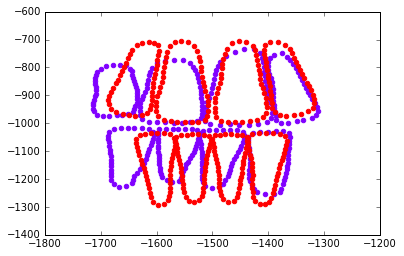

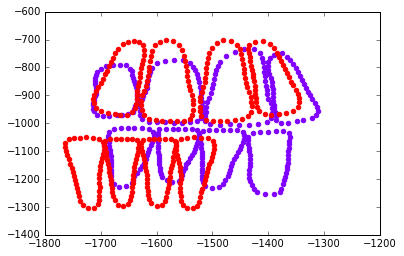

0.47267896679 0.53551394388 0.436974158219


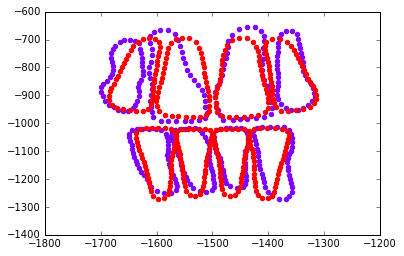

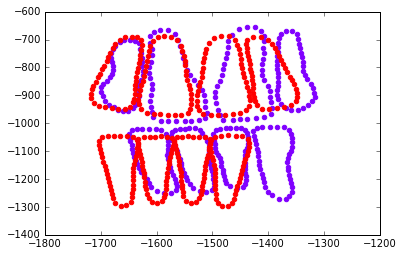

0.586054432496 0.657401366731 0.479186479925


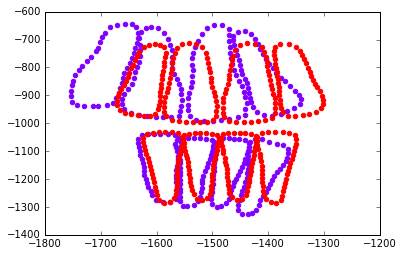

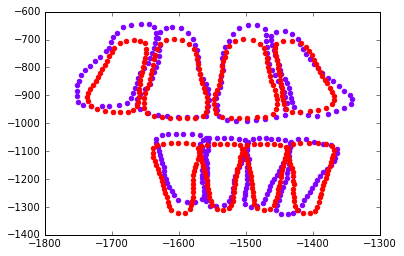

0.46404717724 0.453975513419 0.680421589331


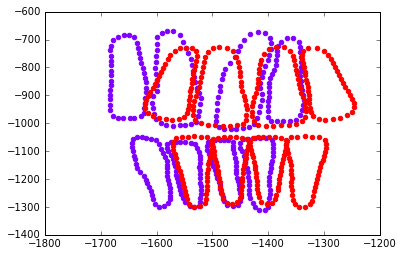

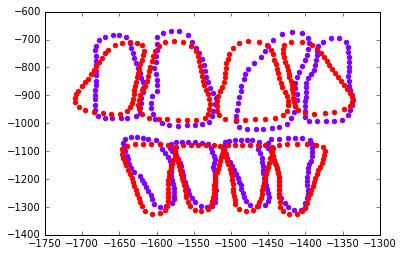

0.557036036839 0.367960741304 0.622495048449


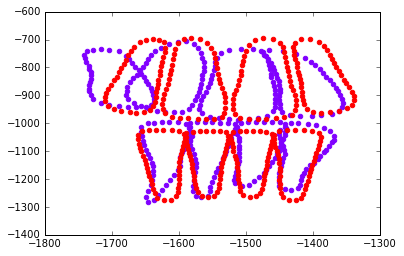

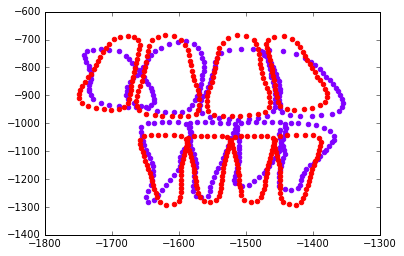

0.525607543098 0.600082300822 0.617816691894


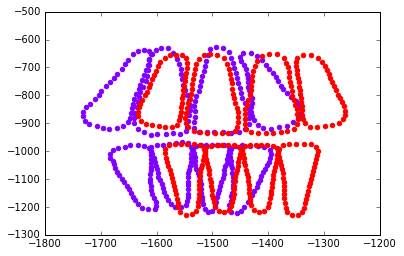

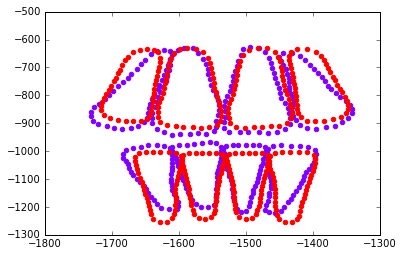

0.474390466597 0.391680193903 0.663406498099


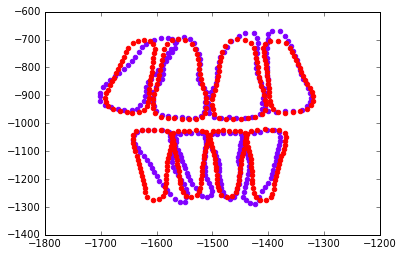

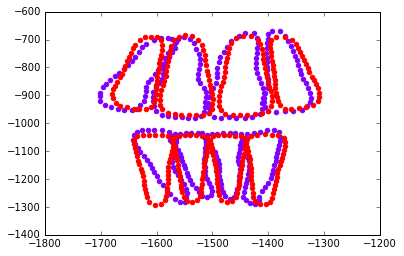

0.681801928181 0.756114549972 0.665615724466


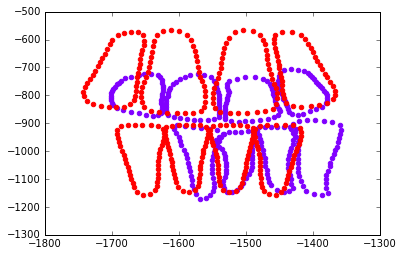

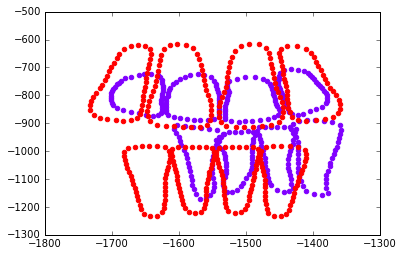

0.388252809655 0.358216936398 0.363996024244


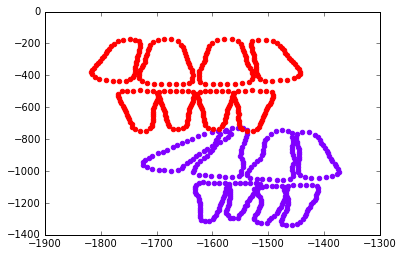

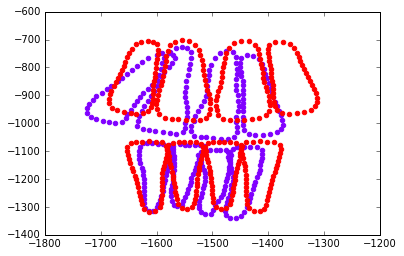

0.407015010679 0.000453316911287 0.446154132632


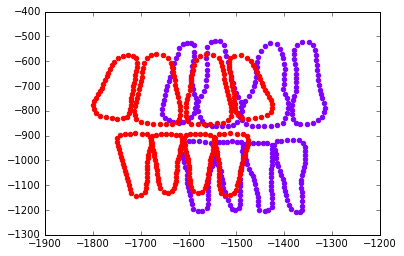

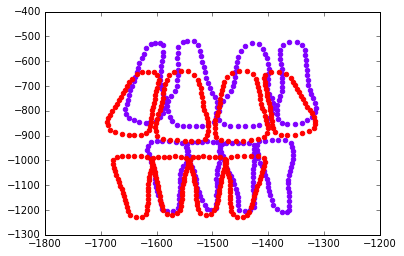

0.310779858208 0.239704184172 0.405563845066


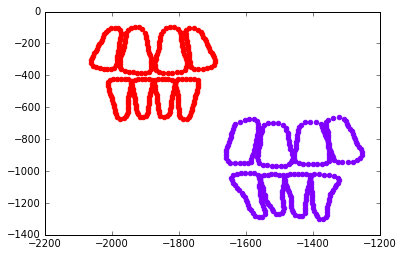

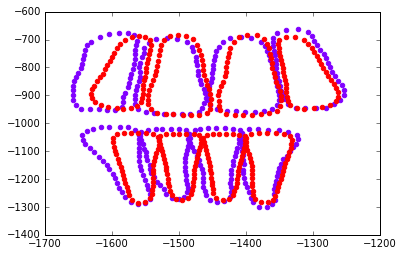

0.478280021318 0.0 0.640085737121


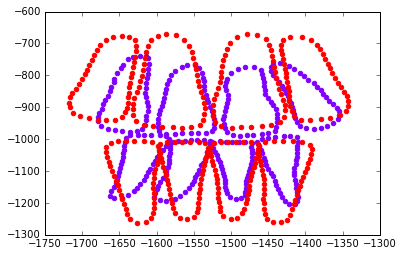

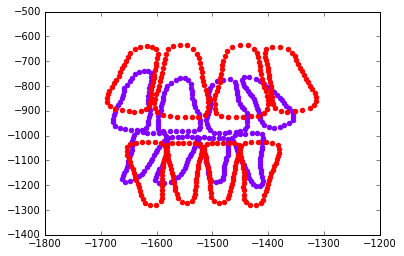

0.419957306903 0.456277805936 0.323179811049


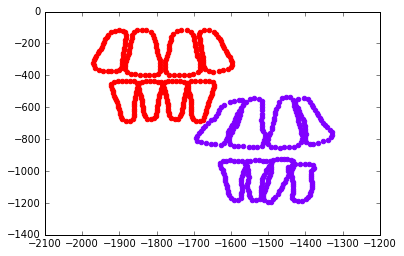

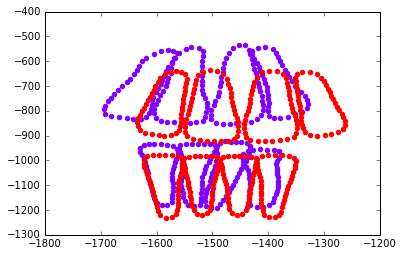

0.377169510935 0.0 0.343526350033


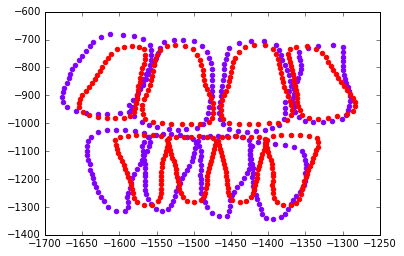

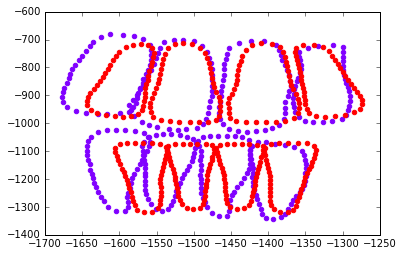

0.505591527568 0.58566375563 0.565191700949


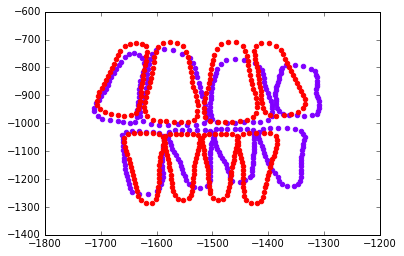

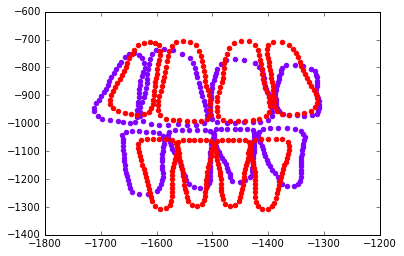

0.496263159786 0.547462612627 0.522049016849


In [14]:
i = 0
for split in LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    transformed_test_image = test_image
    transformed_training_images = training_images
    transformed_training_images = [cv2.medianBlur(image,5) for image in transformed_training_images]
    split_training_landmarks = tooth_splitter(training_landmarks,2)
    transformed_test_image = cv2.medianBlur(transformed_test_image,5)
    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    upper_shape_model = PointDistributionModel(split_training_landmarks[0],pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    lower_shape_model = PointDistributionModel(split_training_landmarks[1],pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    #grey_model = GreyModel(transformed_training_images, training_landmarks,patch_num_pixels_length=4,patch_num_pixels_width=5,
    #                       search_num_pixels=16,use_template_match=False, use_laplacian=True,use_gradient=False,
    #             normalize_patch=True, use_moded_pca_model=False, mpca_variance_captured=0.9,
    #             normal_point_neighborhood=2)
    #active_shape_model = ActiveShapeModel(shape_model,grey_model)
    appearance_model = AppearanceModel(transformed_training_images,shape_model,[1,1],[1,1])
    upper_appearance_model = AppearanceModel(transformed_training_images,upper_shape_model,[1.5,1.5],[2,2])
    lower_appearance_model = AppearanceModel(transformed_training_images,lower_shape_model,[1.5,1.5],[2,2])
    #new_shape,_= grey_model.search(transformed_test_image,test_landmark)
    #newer_shape,_,_ = shape_model.fit(new_shape)
    #newest_shape,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=test_landmark)
    centroid_shape = appearance_model.get_default_shape()
    upper_centroid_shape = upper_appearance_model.get_default_shape()
    lower_centroid_shape = lower_appearance_model.get_default_shape()
    appearance_shape = appearance_model.fit(transformed_test_image)
    upper_appearance_shape = upper_appearance_model.fit(transformed_test_image)
    lower_appearance_shape = lower_appearance_model.fit(transformed_test_image)
    appearance_shape2 = upper_appearance_shape.concatenate(lower_appearance_shape)
    #plot_shapes([test_landmark,new_shape])
    #plot_shapes([test_landmark,newer_shape])
    #plot_shapes([test_landmark,newest_shape])
    plot_shapes([test_landmark,appearance_shape])
    plot_shapes([test_landmark,appearance_shape2])
    #print split.get_dice_error_on_test(new_shape),split.get_dice_error_on_test(newer_shape),split.get_dice_error_on_test(newest_shape),split.get_dice_error_on_test(centroid_shape),split.get_dice_error_on_test(appearance_shape)
    print split.get_dice_error_on_test(centroid_shape),split.get_dice_error_on_test(appearance_shape),split.get_dice_error_on_test(appearance_shape2)
    #error_list.append(split.get_dice_error_on_test(newest_shape))
    i = i+1
    if i >= 1:
        pass#break
#print np.mean(np.array(error_list))